## Load Libraries

In [2]:
from andbro__querrySeismoData import __querrySeismoData
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, append, linspace, mean, median, array, where, transpose, shape, histogram
from pandas import DataFrame, concat, Series

import matplotlib.pyplot as plt

## Configurations

In [22]:

config= {}

config['tbeg'] = UTCDateTime("2022-01-17 00:00")
config['tend'] = UTCDateTime("2022-01-20 00:00")
config['seed'] = "BW.ROMY.10.HJZ"
# config['seed'] = "BW.DROMY..FJZ"


config['opath'] = "/home/andbro/Documents/ROMY/SagnacSpectra/plots/"

## Looping 

In [23]:
st0, inv = __querrySeismoData(    
                            seed_id=config.get('seed'),
                            starttime=config.get('tbeg'),
                            endtime=config.get('tend'),
                            repository="george",
                            path=None,
                            restitute=False,
                            detail=None,
                            )

st0.remove_response(inventory=inv,output="VEL", zero_mean=True); 

In [24]:
def __calculate_spectra(st, config, mode='dB'):

    from datetime import datetime
    from pandas import date_range
    from obspy import UTCDateTime
    from scipy.signal import welch
    from numpy import where, array, zeros
    
    def __check_stream(st):
        t1 = str(st[0].stats.starttime)
        t2 = str(st[0].stats.endtime)
        for tr in st:
            if str(tr.stats.starttime) != t1 or str(tr.stats.endtime) != t2:
                print(f"ERROR: mismatch in start or endtime of trace: {tr.stats.id}")
                return
            
    def __make_decibel(array, relative_value):
        return 10*log10(array/relative_value) 
    
    ## check time consistency for all traces
    __check_stream(st)
    
    ## check how many intervals are possible
    if config['interval_overlap'] is None:
        intervals = int((st[0].stats.endtime - st[0].stats.starttime)/config.get('interval'))
        shift = config['interval']
    else:
        shift = int(config.get('interval')*config['interval_overlap']/100)
        intervals = int((st[0].stats.endtime - st[0].stats.starttime)/shift)
    


    ## pre-define psd array
    size_psd = int(config.get('nperseg')/2)+1
    psd = zeros([intervals, size_psd])
    
    if size_psd >= len(st[0].data):
        print(f"ERROR: reduce nperseg or noverlap or segments! {size_psd} > {len(tr.data)}")
        return
    
    for i, tr in enumerate(st):
        
        # initite variables for while loop
        dt1 = st[0].stats.starttime
        dt2 = st[0].stats.starttime + config['interval']
        n = 0
        
        while dt2 <= st[0].stats.endtime:

            tr_tmp = tr.copy()
            tr_tmp.trim(starttime = UTCDateTime(dt1), endtime=UTCDateTime(dt2))

#             print(n, dt1, dt2, "\n")
            
#             print(config.get('nperseg'), config.get('noverlap'), len(tr_tmp.data))
            
            f, psd0 = welch(  
                        tr_tmp.data, 
                        fs=tr_tmp.stats.sampling_rate, 
                        window=config.get('taper'), 
                        nperseg=config.get('nperseg'), 
                        noverlap=config.get('noverlap'), 
                        nfft=config.get('nfft'), 
                        detrend=config.get('detrend'), 
                        return_onesided=config.get('onesided'), 
                        scaling=config.get('scaling'),
                       )
            psd[n] = psd0
            
            ## adjust variables
            dt1 += shift
            dt2 += shift
            n += 1

            
        if config.get('frequency_limits') is not None:
            f1, f2 = config.get('frequency_limits')[0], config.get('frequency_limits')[1]
            idx1, idx2 = int(where(f <= f1)[0][0]), int(where(f >= f2)[0][0])
            ff = f[idx1:idx2]
            tmp = zeros([intervals, len(ff)])
            for j in range(intervals):
                tmp[j] = psd[j,idx1:idx2]
            psd = tmp

        if mode is not None and mode.lower() == 'db':
            for j in range(intervals):
                psd[j] = __make_decibel(psd[j], abs(max(psd[j])))
   
    return ff, psd

In [25]:
st = st0.copy()

config['interval'] = 3600
config['interval_overlap'] = 50 # in percent
config['taper'] = 'hanning'
config['segments'] = 1e2
config['nperseg'] = 256*config.get('segments')
config['noverlap'] = 64*config.get('segments')
config['nfft'] = None
config['detrend'] = 'constant'
config['scaling'] = 'density'
config['onesided'] = True
config['frequency_limits'] = (0, 30) # in Hz

ff, psds = __calculate_spectra(st, config, mode=None)

In [26]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [27]:
minimal_psd = __get_minimal_psd(psds)

In [39]:
def __get_minimum_psd(psds):
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_sum = psds[0].sum()
            idx = 0

        value = psd.sum()

        if value < lowest_sum and value != 0:
            lowest_sum = value
            idx = i

    return psds[idx]

In [40]:
minimum_psd = __get_minimum_psd(psds)

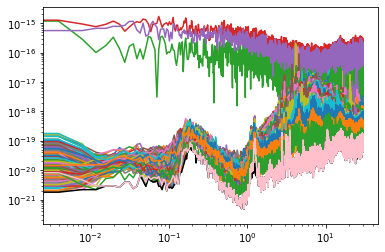

In [42]:
for psd in psds:
    plt.loglog(ff, psd)

plt.loglog(ff, minimal_psd, 'k')
plt.loglog(ff, minimum_psd, 'pink')

plt.show();


In [43]:
## create new dataframe
df = DataFrame(transpose(psd))

## calulcate max and min of all datasets
max_value = max([max(sublist) for sublist in psd])
min_value = min([min(sublist) for sublist in psd])

## make colormap 
# colors = plt.cm.viridis_r(linspace(0,1,len(psd)))
cols = plt.cm.jet_r(linspace(0,1,len(psd)+1))

## caluclate average of each frequency samples across datasets 
psd_avg = df.sum(axis=1)/df.count(axis=1)


TypeError: 'numpy.float64' object is not iterable

### store psd object using pickle

In [44]:
import pickle

ofile = open(opath+'../'+f'sagnacspectra_{date.date}_{interval}.pick', 'wb')
pickle.dump(psd, ofile)
ofile.close()

NameError: name 'opath' is not defined

## Scatter Plot

In [ ]:
## ____________________________________________

fig, ax = plt.subplots(1,1, figsize=(15,10))

font = 14

for i, psdx in enumerate(psd):
    psd_db = __make_decibel(psdx, max_value)
    psd_avg_db = __make_decibel(psd_avg, max_value)
    
#     ax.plot(f, psd_db, color=colors[i])
    ax.scatter(f, psd_db, color=cols[i], s=1, zorder=2, alpha=0.7, label=i,)

ax.plot(f, psd_avg_db, color='k', lw=1, zorder=2)
    
ax.set_xlim(547, 560)

ax.legend(ncol=2)

ax.grid(ls='--', zorder=1)

ax.set_xlabel("Frequency ( Hz )", fontsize=font)
ax.set_ylabel(f"PSD ( dB rel. to {round(max_value,3)} V$^2$/Hz ) ", fontsize=font)
ax.set_title(f"Sagnac Spetra on {date.date} ({interval}s windows) ", fontsize=font+2)

ax.tick_params(axis='both', labelsize=font-2)



In [ ]:
fig.savefig(
            opath+f"plot_sagnacspectra_{date.date}_{interval}_scatter.png", 
            dpi=300, facecolor='w', 
            edgecolor='w',
            orientation='portrait', 
            format="png",
            transparent=False, 
            bbox_inches="tight", 
            pad_inches=0.2,
           )

## Calculate and Plot RollingAverage

In [ ]:
## create second dataframe for rolling average
df_rolled = DataFrame()

# alphabet = [chr(letter) for letter in range(len(df[0]))]

## calulcate rolling average over x samples 
win_len = 10
for i in range(df.columns.size):
    df_rolled = concat([ df_rolled, df.iloc[:,i].rolling(window=win_len, min_periods=1).mean() ], axis=1)


# max_value = max([max(sublist) for sublist in psd])
# min_value = min([min(sublist) for sublist in psd])

## make colormap
# colors = plt.cm.viridis_r(linspace(0,1,len(psd)+1))
cols = plt.cm.jet_r(linspace(0,1,len(psd)+1))

## calulcate average
psd_avg2 = df_rolled.sum(axis=1)/df_rolled.count(axis=1)



In [ ]:
## ____________________________________________

fig, ax = plt.subplots(1,1, figsize=(15,10))

font = 16

for i in range(df_rolled.columns.size):

    psd_db = __make_decibel(df_rolled.iloc[:,i], max_value)
    psd_avg_db = __make_decibel(psd_avg2, max_value)
    
    ax.plot(f, psd_db, color=cols[i], lw=0.8, label=i, alpha=0.6)

    
# ax.plot(f, psd_avg_db, color='k', lw=1, zorder=2)
    
    
ax.set_xlim(547, 560)

ax.legend(ncol=2, markerscale=2)

ax.grid(ls='--', zorder=1)

ax.set_xlabel("Frequency ( Hz )", fontsize=font)
ax.set_ylabel(f"PSD ( dB rel. to {round(max_value,3)} V$^2$/Hz ) ", fontsize=font)
ax.set_title(f"Sagnac Spetra on {date.date} ({interval}s windows) ", fontsize=font+2)

ax.tick_params(axis='both', labelsize=font-2)

ax.set_xlim(546, 560)
# ax.set_xlim(551, 556)


In [ ]:
fig.savefig(
            opath+f"plot_sagnacspectra_{date.date}_{interval}_{win_len}_lines.png", 
            dpi=300, facecolor='w', 
            edgecolor='w',
            orientation='portrait', 
            format="png",
            transparent=False, 
            bbox_inches="tight", 
            pad_inches=0.2,
           )

## Calculate and Plot Density

In [ ]:
psd_db = []
for sublist in psd:
    psd_db.append(__make_decibel(sublist, max_value))

max_value_db = max([max(sublist) for sublist in psd_db])
min_value_db = min([min(sublist) for sublist in psd_db])


dist = []
for h in range(len(psd_db[1])):
    
    tmp = [psd_db[i][h] for i in range(shape(psd_db)[0])]
    hist, edges = histogram(tmp, bins=100, range=(min_value_db, max_value_db), density=None);
    
    dist.append(hist)
    
dist = array(dist)

max_value_dist = max([max(sublist) for sublist in dist])


fig = plt.figure() 
plt.scatter(edges[:-1], hist)


In [ ]:
from matplotlib import colors


fig = plt.figure(figsize=(10,5))

font=14

im = plt.imshow(transpose(dist),
        cmap="YlOrRd",
        clim=[1,20],
        aspect='auto',
        interpolation=None,
        alpha=None,
        origin="lower",
        extent=(f_lower, f_upper, min(edges), max(edges)),
        norm=colors.LogNorm()
)

plt.plot(f, psd_avg_db, color='k', lw=1, zorder=2)

caxes = fig.add_axes()

cb = plt.colorbar(im, cax=caxes)
cb.set_label("counts", fontsize=font)

plt.ylabel(f"PSD (dB rel. to {round(max_value,3)} V$^2$/Hz )",fontsize=font)
plt.xlabel("Frequency ( Hz )",fontsize=font)
plt.title(f"Sagnac Spetra on {date.date} ({interval}s windows) ",fontsize=font+2)

plt.tick_params(axis='both', labelsize=font-2)


In [ ]:

fig.savefig(
            opath+f"plot_sagnacspectra_{date.date}_{interval}_distribution.png", 
            dpi=300, facecolor='w', 
            edgecolor='w',
            orientation='portrait', 
            format="png",
            transparent=False, 
            bbox_inches="tight", 
            pad_inches=0.2,
           )